In [25]:
import numpy as np
import pandas as pd
import nltk
import spacy
import joblib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nrclex import NRCLex

In [26]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kbeni\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [27]:
# read preprocessed data
data = pd.read_csv("Data/prepro_mergerdata.csv")

In [28]:
# rename first column to number
data = data.rename(columns={'Unnamed: 0': 'number'})
data

,number,date_completion,bidders_name,date_completion_assumed,date_last_status_update,status,bidders_industry,id,comments,targets_industry,...,targets_country,type,targets_name,bidders_country,sentences,cleaned_sentences,stemmed_sentences,lemmatized_sentences,pos_tagged_sentences,dependency_parsed_sentences
0,17,2014-07-31,['jaya hind investments pvt ltd'],NaN,NaN,Completed,['6499'],1907056319,2014-08-01: it was announced that on 31/07/14 ...,['2910'],...,['IN'],Acquisition 3.188%,['force motors ltd'],['IN'],['2014-08-01: it was announced that on 31/07/1...,['20140801 it was announced that on 310714 jay...,['20140801 it wa announc that on 310714 jaya h...,['20140801 it be announce that on 310714 jaya ...,"[[('20140801', 'CD'), ('it', 'PRP'), ('was', '...","[[('20140801', 'npadvmod', 'announced'), ('it'..."
1,162,2022-07-22,"['cwb automotive electronics co., ltd']",NaN,NaN,Completed,['2931'],1943340721,2022-04-27: it was announced that CWB Automoti...,['2561'],...,['CN'],Acquisition increased from 100% to 100%,"['yueqing guanghe surface treatment co., ltd']",['CN'],['2022-04-27: it was announced that CWB Automo...,['20220427 it was announced that cwb automotiv...,['20220427 it wa announc that cwb automot elec...,['20220427 it be announce that cwb automotive ...,"[[('20220427', 'CD'), ('it', 'PRP'), ('was', '...","[[('20220427', 'npadvmod', 'announced'), ('it'..."
2,238,NaN,"['beijing bdstar navigation co., ltd']",2021-09-16,NaN,Completed Assumed,['2651'],1943132402,2019-09-16: it was announced that Beijing BDSt...,['4669'],...,['CN'],Acquisition increased from 80% to 90%,['beijing beidou xingtong positioning technolo...,['CN'],['2019-09-16: it was announced that Beijing BD...,['20190916 it was announced that beijing bdsta...,['20190916 it wa announc that beij bdstar navi...,['20190916 it be announce that beijing bdstar ...,"[[('20190916', 'CD'), ('it', 'PRP'), ('was', '...","[[('20190916', 'npadvmod', 'announced'), ('it'..."
3,259,2015-06-02,"['patec precision industry co., ltd']",NaN,NaN,Completed,['2932'],1907102483,2015-06-02: it was announced that Patec Precis...,['2932'],...,['SG'],Acquisition increased from 100% to 100%,['patec pte ltd'],['KY'],['2015-06-02: it was announced that Patec Prec...,['20150602 it was announced that patec precisi...,['20150602 it wa announc that patec precis ind...,['20150602 it be announce that patec precision...,"[[('20150602', 'CD'), ('it', 'PRP'), ('was', '...","[[('20150602', 'npadvmod', 'announced'), ('it'..."
4,300,NaN,['china automotive holdings ltd'],NaN,2021-01-27,Withdrawn,['4519'],1941252521,2019-04-23: it was announced that Sprintex Ltd...,['2931'],...,['AU'],Acquisition unknown stake %,['sprintex ltd'],['CN'],['2019-04-23: it was announced that Sprintex L...,['20190423 it was announced that sprintex ltd ...,['20190423 it wa announc that sprintex ltd a m...,['20190423 it be announce that sprintex ltd a ...,"[[('20190423', 'CD'), ('it', 'PRP'), ('was', '...","[[('20190423', 'npadvmod', 'announced'), ('it'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,824785,NaN,"['changzhou tenglong auto parts co., ltd']",2018-03-23,NaN,Completed Assumed,['2930'],1907148524,2016-03-23: it was announced that Changzhou Te...,['2932'],...,['CN'],Acquisition increased from 100% to 100%,"['xiamen dajun accurate industrial co., ltd']",['CN'],['2016-03-23: it was announced that Changzhou ...,['20160323 it was announced that changzhou ten...,['20160323 it wa announc that changzhou tenglo...,['20160323 it be announce that changzhou tengl...,"[[('20160323', 'CD'), ('it', 'PRP'), ('was', '...","[[('20160323', 'npadvmod', 'announced'), ('it'..."
3391,824819,2017-12-06,"['zhejiang tiantie industry co., ltd']",NaN,2017-12-08,Completed,['2219'],1943003558,2017-11-20: it was announced that Zhejiang Tia...,['2899'],...,['CN'],Acquisition 51%,"['hebei lutong railway equipment co., ltd']",['CN'],['2017-11-20: it was announced that Zhejiang T...,['20171120 it was announc

In [29]:
lemmatized_text = data['lemmatized_sentences'].apply(lambda x: " ".join(eval(x)))

**Feature Engineering**

In this section, we will perform feature engineering on the preprocessed data. We will use the following techniques:
- TF-IDF
- BERT embeddings

In [30]:
# feature engineering using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_text)

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df.to_csv("Data/tfidf.csv", index=False)

In [31]:
# feature engineering using BERT embeddings

# check if model exists in Models/ directory
try:
    # Try loading the model and embeddings
    model = joblib.load('Models/bert_model.pkl')
    embeddings_df = pd.read_csv("Data/embeddings.csv")
    print("Model and embeddings found.")
    print("Loaded embeddings:\n", embeddings_df.head())
except (FileNotFoundError, EOFError):  # Catch specific errors for missing files
    print("Model or embeddings not found. Generating new ones...")

    model = SentenceTransformer('all-MiniLM-L6-v2')

    sentence_embeddings = model.encode(lemmatized_text, show_progress_bar=True)

    embeddings_df = pd.DataFrame(sentence_embeddings)
    print("Generated embeddings:\n", embeddings_df.head())

    # Save the model
    joblib.dump(model, 'Models/bert_model.pkl')

    # Save the embeddings
    embeddings_df.to_csv("Data/embeddings.csv", index=False)

Model or embeddings not found. Generating new ones...


Batches: 100%|██████████| 107/107 [00:50<00:00,  2.10it/s]


Generated embeddings:
         0         1         2         3         4         5         6    \
0 -0.052809 -0.038020 -0.016260 -0.046810 -0.011117  0.087446  0.002803   
1 -0.032618 -0.028144  0.073250 -0.034925 -0.047233  0.008898  0.029912   
2 -0.063489 -0.015513  0.026258 -0.077508 -0.047614  0.030812  0.082038   
3 -0.061746 -0.042415  0.027517 -0.031067 -0.056502 -0.050850 -0.023097   
4 -0.081837 -0.020603 -0.000074 -0.044521 -0.049744  0.032372  0.012290   

        7         8         9    ...       374       375       376       377  \
0  0.106155  0.009057  0.017922  ... -0.042708  0.045368 -0.141863  0.019185   
1  0.020383 -0.031529 -0.017767  ... -0.050487  0.066955 -0.090817  0.009161   
2  0.059187 -0.019487  0.013194  ...  0.023294  0.097975 -0.032301 -0.066112   
3  0.056935  0.035830 -0.028737  ... -0.068408  0.022757 -0.101495 -0.092565   
4  0.102173 -0.036398  0.005273  ...  0.005733  0.064733 -0.078019 -0.015810   

        378       379       380       381    

In [32]:
# save a test set of 100 entries
tfidf_df.sample(100).to_csv("Data/test_tfidf.csv")

embeddings_df.sample(100).to_csv("Data/test_embeddings.csv")

**Sentiment Analysis**

In this section, we will perform sentiment analysis on the preprocessed data. We will use the following techniques:
- VADER sentiment analysis
- Named entity recognition
- Topic modelling
- Emotion detection

In [33]:
# vader sentiment analysis
sia = SentimentIntensityAnalyzer()

data['sentiment'] = data['lemmatized_sentences'].apply(lambda x: sia.polarity_scores(x)['compound'])

def classify_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

data['vader_sentiment'] = data['sentiment'].apply(classify_sentiment)

data

,number,date_completion,bidders_name,date_completion_assumed,date_last_status_update,status,bidders_industry,id,comments,targets_industry,...,targets_name,bidders_country,sentences,cleaned_sentences,stemmed_sentences,lemmatized_sentences,pos_tagged_sentences,dependency_parsed_sentences,sentiment,vader_sentiment
0,17,2014-07-31,['jaya hind investments pvt ltd'],NaN,NaN,Completed,['6499'],1907056319,2014-08-01: it was announced that on 31/07/14 ...,['2910'],...,['force motors ltd'],['IN'],['2014-08-01: it was announced that on 31/07/1...,['20140801 it was announced that on 310714 jay...,['20140801 it wa announc that on 310714 jaya h...,['20140801 it be announce that on 310714 jaya ...,"[[('20140801', 'CD'), ('it', 'PRP'), ('was', '...","[[('20140801', 'npadvmod', 'announced'), ('it'...",0.9118,positive
1,162,2022-07-22,"['cwb automotive electronics co., ltd']",NaN,NaN,Completed,['2931'],1943340721,2022-04-27: it was announced that CWB Automoti...,['2561'],...,"['yueqing guanghe surface treatment co., ltd']",['CN'],['2022-04-27: it was announced that CWB Automo...,['20220427 it was announced that cwb automotiv...,['20220427 it wa announc that cwb automot elec...,['20220427 it be announce that cwb automotive ...,"[[('20220427', 'CD'), ('it', 'PRP'), ('was', '...","[[('20220427', 'npadvmod', 'announced'), ('it'...",0.3612,positive
2,238,NaN,"['beijing bdstar navigation co., ltd']",2021-09-16,NaN,Completed Assumed,['2651'],1943132402,2019-09-16: it was announced that Beijing BDSt...,['4669'],...,['beijing beidou xingtong positioning technolo...,['CN'],['2019-09-16: it was announced that Beijing BD...,['20190916 it was announced that beijing bdsta...,['20190916 it wa announc that beij bdstar navi...,['20190916 it be announce that beijing bdstar ...,"[[('20190916', 'CD'), ('it', 'PRP'), ('was', '...","[[('20190916', 'npadvmod', 'announced'), ('it'...",0.2960,positive
3,259,2015-06-02,"['patec precision industry co., ltd']",NaN,NaN,Completed,['2932'],1907102483,2015-06-02: it was announced that Patec Precis...,['2932'],...,['patec pte ltd'],['KY'],['2015-06-02: it was announced that Patec Prec...,['20150602 it was announced that patec precisi...,['20150602 it wa announc that patec precis ind...,['20150602 it be announce that patec precision...,"[[('20150602', 'CD'), ('it', 'PRP'), ('was', '...","[[('20150602', 'npadvmod', 'announced'), ('it'...",-0.2960,negative
4,300,NaN,['china automotive holdings ltd'],NaN,2021-01-27,Withdrawn,['4519'],1941252521,2019-04-23: it was announced that Sprintex Ltd...,['2931'],...,['sprintex ltd'],['CN'],['2019-04-23: it was announced that Sprintex L...,['20190423 it was announced that sprintex ltd ...,['20190423 it wa announc that sprintex ltd a m...,['20190423 it be announce that sprintex ltd a ...,"[[('20190423', 'CD'), ('it', 'PRP'), ('was', '...","[[('20190423', 'npadvmod', 'announced'), ('it'...",0.9531,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,824785,NaN,"['changzhou tenglong auto parts co., ltd']",2018-03-23,NaN,Completed Assumed,['2930'],1907148524,2016-03-23: it was announced that Changzhou Te...,['2932'],...,"['xiamen dajun accurate industrial co., ltd']",['CN'],['2016-03-23: it was announced that Changzhou ...,['20160323 it was announced that changzhou ten...,['20160323 it wa announc that changzhou tenglo...,['20160323 it be announce that changzhou tengl...,"[[('20160323', 'CD'), ('it', 'PRP'), ('was', '...","[[('20160323', 'npadvmod', 'announced'), ('it'...",0.1779,positive
3391,824819,2017-12-06,"['zhejiang tiantie industry co., ltd']",NaN,2017-12-08,Completed,['2219'],1943003558,2017-11-20: it was announced that Zhejiang Tia...,['2899'],...,"['hebei lutong railway equipment co., ltd']",['CN'],['2017-11-20: it was announced that Zhejiang T...,['20171120 it was announced that zhejiang tian...,['20171120 it wa announc that zhejiang tianti ...,['20171120 it be announce that zhejiang tianti...,"[[('20171120', 'CD'), ('it', 'PRP'), ('was

In [34]:
# Named entity recognition
try:
    nlp = joblib.load('Models/nlp_model.pkl')
    print("Model found.")
except (FileNotFoundError, EOFError):
    print("Model not found. Generating new one...")
    nlp = spacy.load('en_core_web_sm')
    joblib.dump(nlp, 'Models/nlp_model.pkl')

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

data["named_entities"] = data['lemmatized_sentences'].apply(extract_entities)
data

Model found.


,number,date_completion,bidders_name,date_completion_assumed,date_last_status_update,status,bidders_industry,id,comments,targets_industry,...,bidders_country,sentences,cleaned_sentences,stemmed_sentences,lemmatized_sentences,pos_tagged_sentences,dependency_parsed_sentences,sentiment,vader_sentiment,named_entities
0,17,2014-07-31,['jaya hind investments pvt ltd'],NaN,NaN,Completed,['6499'],1907056319,2014-08-01: it was announced that on 31/07/14 ...,['2910'],...,['IN'],['2014-08-01: it was announced that on 31/07/1...,['20140801 it was announced that on 310714 jay...,['20140801 it wa announc that on 310714 jaya h...,['20140801 it be announce that on 310714 jaya ...,"[[('20140801', 'CD'), ('it', 'PRP'), ('was', '...","[[('20140801', 'npadvmod', 'announced'), ('it'...",0.9118,positive,"[(20140801, DATE), (310714, CARDINAL), (pvt lt..."
1,162,2022-07-22,"['cwb automotive electronics co., ltd']",NaN,NaN,Completed,['2931'],1943340721,2022-04-27: it was announced that CWB Automoti...,['2561'],...,['CN'],['2022-04-27: it was announced that CWB Automo...,['20220427 it was announced that cwb automotiv...,['20220427 it wa announc that cwb automot elec...,['20220427 it be announce that cwb automotive ...,"[[('20220427', 'CD'), ('it', 'PRP'), ('was', '...","[[('20220427', 'npadvmod', 'announced'), ('it'...",0.3612,positive,"[(20220427, DATE), (automotive electronics co ..."
2,238,NaN,"['beijing bdstar navigation co., ltd']",2021-09-16,NaN,Completed Assumed,['2651'],1943132402,2019-09-16: it was announced that Beijing BDSt...,['4669'],...,['CN'],['2019-09-16: it was announced that Beijing BD...,['20190916 it was announced that beijing bdsta...,['20190916 it wa announc that beij bdstar navi...,['20190916 it be announce that beijing bdstar ...,"[[('20190916', 'CD'), ('it', 'PRP'), ('was', '...","[[('20190916', 'npadvmod', 'announced'), ('it'...",0.2960,positive,"[('20190916, DATE), (beijing, GPE), (5 million..."
3,259,2015-06-02,"['patec precision industry co., ltd']",NaN,NaN,Completed,['2932'],1907102483,2015-06-02: it was announced that Patec Precis...,['2932'],...,['KY'],['2015-06-02: it was announced that Patec Prec...,['20150602 it was announced that patec precisi...,['20150602 it wa announc that patec precis ind...,['20150602 it be announce that patec precision...,"[[('20150602', 'CD'), ('it', 'PRP'), ('was', '...","[[('20150602', 'npadvmod', 'announced'), ('it'...",-0.2960,negative,"[('20150602, DATE), (5 million, CARDINAL)]"
4,300,NaN,['china automotive holdings ltd'],NaN,2021-01-27,Withdrawn,['4519'],1941252521,2019-04-23: it was announced that Sprintex Ltd...,['2931'],...,['CN'],['2019-04-23: it was announced that Sprintex L...,['20190423 it was announced that sprintex ltd ...,['20190423 it wa announc that sprintex ltd a m...,['20190423 it be announce that sprintex ltd a ...,"[[('20190423', 'CD'), ('it', 'PRP'), ('was', '...","[[('20190423', 'npadvmod', 'announced'), ('it'...",0.9531,positive,"[(sprintex ltd, ORG), (11939765, DATE), (36445..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,824785,NaN,"['changzhou tenglong auto parts co., ltd']",2018-03-23,NaN,Completed Assumed,['2930'],1907148524,2016-03-23: it was announced that Changzhou Te...,['2932'],...,['CN'],['2016-03-23: it was announced that Changzhou ...,['20160323 it was announced that changzhou ten...,['20160323 it wa announc that changzhou tenglo...,['20160323 it be announce that changzhou tengl...,"[[('20160323', 'CD'), ('it', 'PRP'), ('was', '...","[[('20160323', 'npadvmod', 'announced'), ('it'...",0.1779,positive,"[(20160323, DATE), (changzhou, GPE), (three, C..."
3391,824819,2017-12-06,"['zhejiang tiantie industry co., ltd']",NaN,2017-12-08,Completed,['2219'],1943003558,2017-11-20: it was announced that Zhejiang Tia...,['2899'],...,['CN'],['2017-11-20: it was announced that Zhejiang T...,['20171120 it was announced that zhejiang tian...,['20171120 it wa announc that zhejiang tianti ...,['20171120 it be announce that zhej

In [35]:
# topic modelling
count_vectorizer = CountVectorizer(max_features=1000, stop_words='english')
doc_term_matrix = count_vectorizer.fit_transform(lemmatized_text)

try:
    lda = joblib.load('Models/lda_model.pkl')
    print("Model found.")
except (FileNotFoundError, EOFError):
    print("Model not found. Generating new one...")
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(doc_term_matrix)
    joblib.dump(lda, 'Models/lda_model.pkl')

for i, topic in enumerate(lda.components_):
    print(f"Top 10 words for topic #{i}:")
    print([count_vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])
    print("\n")

# topics value
topics_values = lda.transform(doc_term_matrix)
data['topic'] = topics_values.argmax(axis=1)

Model found.
Top 10 words for topic #0:
['automotive', 'state', 'automobile', 'motor', 'disclose', 'acquisition', 'manufacturer', 'billion', 'company', 'report']


Top 10 words for topic #1:
['million', 'mr', 'acquire', 'consideration', 'cny', 'announce', 'share', 'transaction', 'stake', 'cent']


Top 10 words for topic #2:
['subject', 'automotive', 'company', 'expect', 'manufacturer', 'disclose', 'complete', 'acquire', 'transaction', 'announce']


Top 10 words for topic #3:
['closing', 'transaction', 'base', 'offer', 'announce', 'acquire', 'price', 'stake', 'cent', 'share']


Top 10 words for topic #4:
['chinabase', 'register', 'manufacturer', 'completion', 'inject', 'subsidiary', 'announce', 'cny', 'capital', 'million']




In [36]:
# emotion detection
data['emotion'] = data['lemmatized_sentences'].apply(lambda x: NRCLex(" ".join(eval(x))).top_emotions)

# Display results
print(data[['lemmatized_sentences', 'emotion']].head())

                                lemmatized_sentences                 emotion
0  ['20140801 it be announce that on 310714 jaya ...      [(positive, 0.25)]
1  ['20220427 it be announce that cwb automotive ...       [(positive, 0.5)]
2  ['20190916 it be announce that beijing bdstar ...      [(positive, 0.45)]
3  ['20150602 it be announce that patec precision...       [(positive, 1.0)]
4  ['20190423 it be announce that sprintex ltd a ...  [(positive, 0.296875)]


In [37]:
# save the final data
data.to_csv("Data/final_data.csv")

** Visualization **

In this section, we will visualize the results of the feature engineering and sentiment analysis.

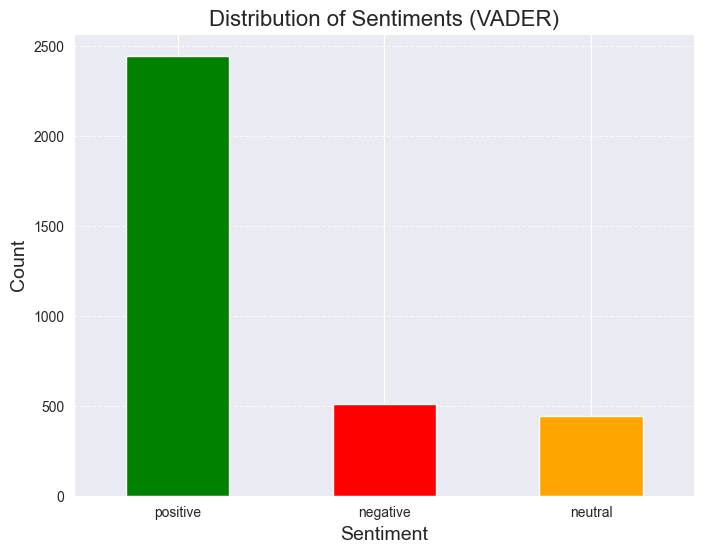

In [38]:
# Count the distribution of categorical sentiment (vader_sentiment)
sentiment_counts = data['vader_sentiment'].value_counts()

# Bar chart for categorical sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'orange'])
plt.title('Distribution of Sentiments (VADER)', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

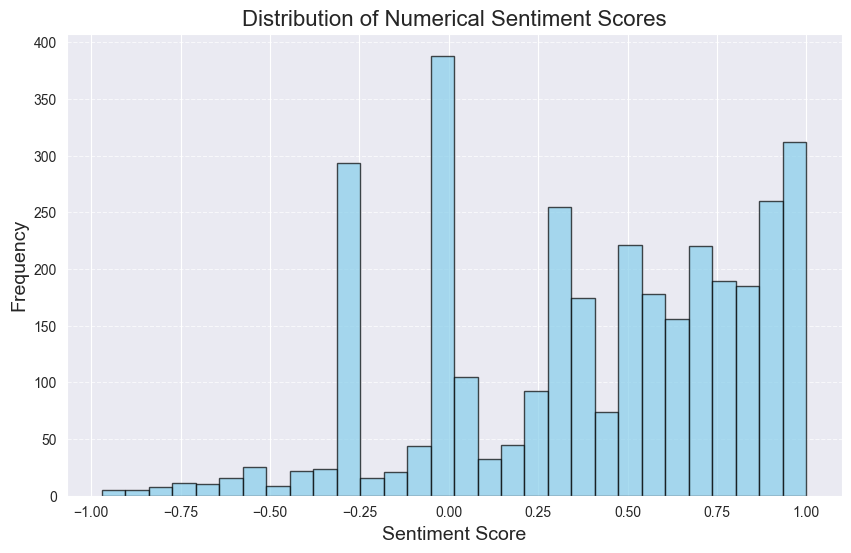

In [39]:
# Histogram for numerical sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(data['sentiment'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Numerical Sentiment Scores', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

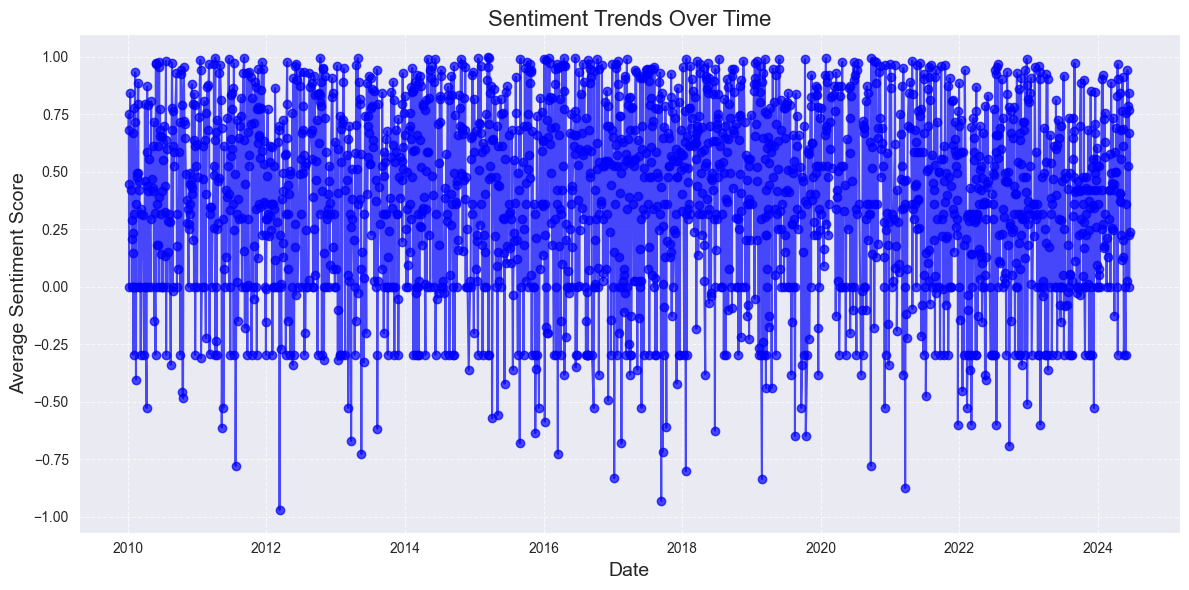

In [40]:
# Convert date_completion to datetime format for trend analysis
data['date_rumor'] = pd.to_datetime(data['date_rumor'], errors='coerce')

# Group by date to calculate average sentiment score per day
sentiment_trend = data.groupby('date_rumor')['sentiment'].mean().dropna()

# Plot sentiment trends over time
plt.figure(figsize=(12, 6))
plt.plot(sentiment_trend.index, sentiment_trend.values, color='blue', marker='o', linestyle='-', alpha=0.7)
plt.title('Sentiment Trends Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


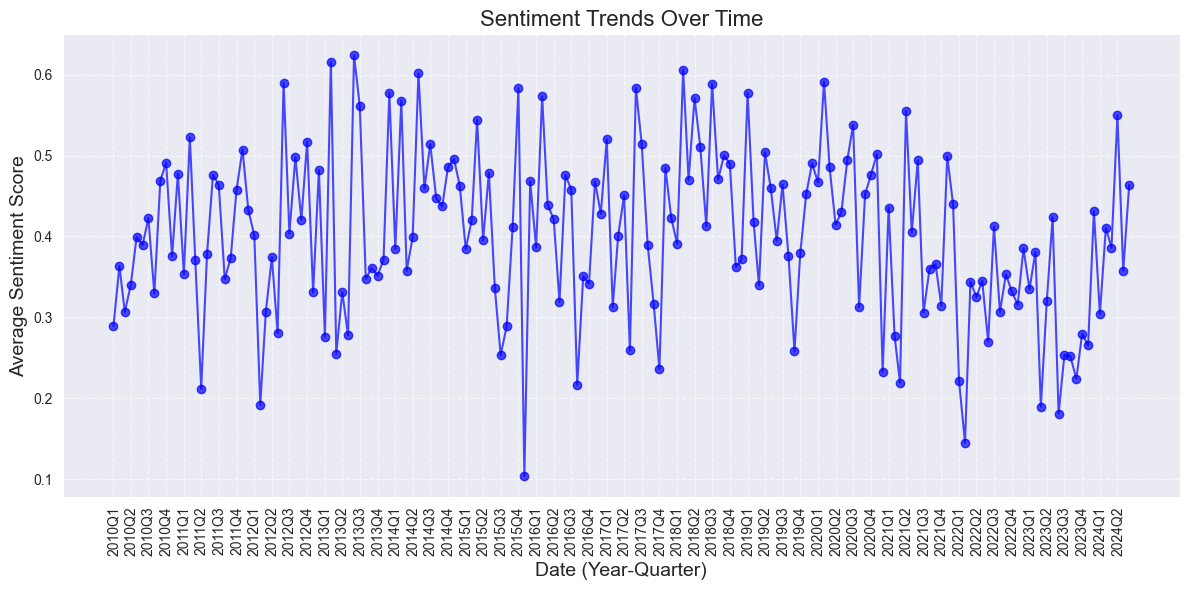

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert date_rumor to datetime format for trend analysis
data['date_rumor'] = pd.to_datetime(data['date_rumor'], errors='coerce')

# Extract year and month from date_rumor
data['year_month'] = data['date_rumor'].dt.to_period('M')

# Group by year and month to calculate average sentiment score per month
sentiment_trend = data.groupby('year_month')['sentiment'].mean().dropna()

# Convert index to timestamp for easier handling and period manipulation
sentiment_trend.index = sentiment_trend.index.to_timestamp()

# Extract quarters from the time index
quarters = sentiment_trend.index.to_period('Q').unique()

# Plot sentiment trends over time
plt.figure(figsize=(12, 6))
plt.plot(sentiment_trend.index, sentiment_trend.values, color='blue', marker='o', linestyle='-', alpha=0.7)
plt.title('Sentiment Trends Over Time', fontsize=16)
plt.xlabel('Date (Year-Quarter)', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Set x-axis ticks to display only the quarters
plt.xticks(
    ticks=[pd.Timestamp(q.start_time) for q in quarters],
    labels=[str(q) for q in quarters],
    rotation=90
)

plt.tight_layout()
plt.show()
